



# MODELLING



In [3]:
# Import the necessary Modules required for the modelling process
import pandas as pd
import re

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from imblearn.over_sampling import SMOTE

# Download required NLTK data
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


# Numpy
import numpy as np

import os

# PyTorch
import torch


# Sklearn
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from nltk.stem.porter import PorterStemmer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Pickle
import pickle

# Transformers
from transformers import pipeline
from transformers import BertTokenizer,TFBertModel

# Warnings
import warnings
# Ignore all warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message=r".*Some weights of.*not used.*")


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


### Load Dataset



Load the `2024-olympics-sentiments.csv` dataset inorder to only work with the `Tweet_Content` column

In [5]:
# Load Dataset
df = pd.read_csv('2024-olympics-sentiments.csv')
# Get the info of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53171 entries, 0 to 53170
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Category                  53171 non-null  object
 1   Keyword                   53171 non-null  object
 2   Web_Page_URL              53171 non-null  object
 3   Tweet_Website             53171 non-null  object
 4   Author_Name               53132 non-null  object
 5   Author_Web_Page_URL       53171 non-null  object
 6   Tweet_Timestamp           49848 non-null  object
 7   Tweet_Content             53153 non-null  object
 8   Tweet_Image_URL           25043 non-null  object
 9   Tweet_Video_URL           53171 non-null  object
 10  Tweet_AD                  53171 non-null  bool  
 11  Tweet_Number_of_Reviews   39908 non-null  object
 12  Tweet_Number_of_Retweets  45432 non-null  object
 13  Tweet_Number_of_Likes     50328 non-null  object
 14  Tweet_Number_of_Looks 

In [6]:
# Selecting Only the column `Tweet_Content` column from the Dataframe
df = df[['Tweet_Content']]
df.head()

,Tweet_Content
0,Olympic Legends. #USABMNT #Paris2024 #Basketball
1,We've created footwear that not only feels inc...
2,#OLYMPICRECORD FOR RIZKI JUNIANSYAH! @iwfnet |...
3,Everyone is watching the ball. Except for him....
4,Men's javelin throw final was BIG 92.97m OR A...


In [52]:
# Dropping Duplicate values and null values in the dataset
def check_and_clean_data(df):
    """
    Function to check for null values, duplicated rows, and clean the dataset.

    Parameters:
    df (pd.DataFrame): The DataFrame to be checked and cleaned.

    Returns:
    tuple: A tuple containing the total number of null values, the total number of duplicated rows,
           and the cleaned DataFrame with null values and duplicates removed.
    """
    # Check for null values
    total_null_values = df.isna().sum().sum()

    # Check for duplicated rows
    total_duplicates = df.duplicated().sum()

    # Drop duplicates
    df_cleaned = df.drop_duplicates()

    # Drop rows with null values
    df_cleaned = df_cleaned.dropna()

    return total_null_values, total_duplicates, df_cleaned


total_nulls, total_dupes, df_cleaned = check_and_clean_data(df)

print(f"Total null values in the dataset: {total_nulls}")
print(f"Total duplicated rows in the dataset: {total_dupes}")
print(f"Shape of the cleaned dataset: {df_cleaned.shape}")


Total null values in the dataset: 0
Total duplicated rows in the dataset: 0
Shape of the cleaned dataset: (5276, 9)


### Remove Corrupted Text

This function removes the corrupted text in the `Tweet_Content` column

In [14]:
def remove_corrupted_text(text):
    """
    Cleans the input text by:
    - Removing non-ASCII characters
    - Removing sequences of repeated characters
    - Removing special symbols and corrupted characters
    - Keeping only English alphabet, digits, and some punctuation
    """
    if not isinstance(text, str):
        return ''

    # Remove non-ASCII characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove repeated characters (e.g., "û û" becomes " ")
    text = re.sub(r'(.)\1{2,}', r'\1', text)

    # Remove special symbols or corrupted characters
    text = re.sub(r'[^\w\s,.!?\'"-]', '', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english') + ['ø³','ø', 'ù'])
lemmatizer = WordNetLemmatizer()
import emoji
import string

def replace_emojis(text):
    """
    Converts emojis in the text to their corresponding word descriptions.
    """
    return emoji.demojize(text, delimiters=(" ", " "))

def lemmatize_tweet(text):
    # Remove corrupted text
    text = remove_corrupted_text(text)

    # Convert emojis to words
    text = replace_emojis(text)

    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text after the #)
    text = re.sub(r'#', '', text)
    # Remove special characters like "&quot;"
    text = re.sub(r'&\w+;', '', text)
    # Remove punctuation
    text = "".join([char for char in text if char not in string.punctuation])
    # Tokenize text
    tokens = re.split('\W+', text.lower())
    # Remove stopwords and lemmatize the tokens
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # Remove extra white spaces
    tokens = [word.strip() for word in tokens if word.strip() != '']
    # Remove numbers
    tokens = [word for word in tokens if not word.isdigit()]
    # Tag parts of speech
    pos_tags = nltk.pos_tag(tokens)
    # Filter tokens to retain only nouns, adjectives, verbs, and adverbs
    important_pos = {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
    tokens = [word for word, tag in pos_tags if tag in important_pos]

    return tokens

def join_text(tokens):
    """
    This function takes a list of tokens (words) and returns them as a single string.
    Each token is separated by a space.
    """
    return " ".join(tokens)




In [17]:
df['Clean_Tweet'] = df['Tweet_Content'].apply(lemmatize_tweet)
df['Clean_Tweet'] = df['Clean_Tweet'].apply(join_text)

# Now, the DataFrame df will have a new column 'Cleaned_Tweet' with processed tweets
df = df[['Tweet_Content', 'Clean_Tweet']]

In [18]:
df.shape

(5276, 2)

Pseudo Sentiment assignment

In [19]:
#Vader
# Initialize the SentimentIntensityAnalyzer
sentiments = SentimentIntensityAnalyzer()

# Calculate polarity scores for each tweet and store them in new columns in the DataFrame df
df["Positive"] = [sentiments.polarity_scores(tweet)["pos"] for tweet in df["Clean_Tweet"]]
df["Negative"] = [sentiments.polarity_scores(tweet)["neg"] for tweet in df["Clean_Tweet"]]
df["Neutral"] = [sentiments.polarity_scores(tweet)["neu"] for tweet in df["Clean_Tweet"]]
df['Compound'] = [sentiments.polarity_scores(tweet)["compound"] for tweet in df["Clean_Tweet"]]

# Print the first few rows of the DataFrame to see the results
df.shape

(5276, 6)

In [20]:
score = df["Compound"].values
sentiment = []
for i in score:
    if i >= 0.05 :
        sentiment.append('Positive')
    elif i <= -0.05 :
        sentiment.append('Negative')
    else:
        sentiment.append('Neutral')
df["Sentiment"] = sentiment
df.head()

,Tweet_Content,Clean_Tweet,Positive,Negative,Neutral,Compound,Sentiment
0,Olympic Legends. #USABMNT #Paris2024 #Basketball,olympic legend usabmnt paris2024 basketball,0.00,0.0,1.00,0.0000,Neutral
1,We've created footwear that not only feels inc...,weve created footwear feel incredible also imp...,0.36,0.0,0.64,0.8648,Positive
2,#OLYMPICRECORD FOR RIZKI JUNIANSYAH! @iwfnet |...,olympicrecord rizki juniansyah iwfnet weightli...,0.00,0.0,1.00,0.0000,Neutral
3,Everyone is watching the ball. Except for him....,everyone watching ball himparis2024 basketball,0.00,0.0,1.00,0.0000,Neutral
4,Men's javelin throw final was BIG 92.97m OR A...,men javelin throw final big arshad nadeem neer...,0.00,0.0,1.00,0.0000,Neutral


Class imbalance solution

In [21]:
#Distribution of sentiments
print(df['Sentiment'].value_counts())

Sentiment
Neutral     2880
Positive    1992
Negative     404
Name: count, dtype: int64


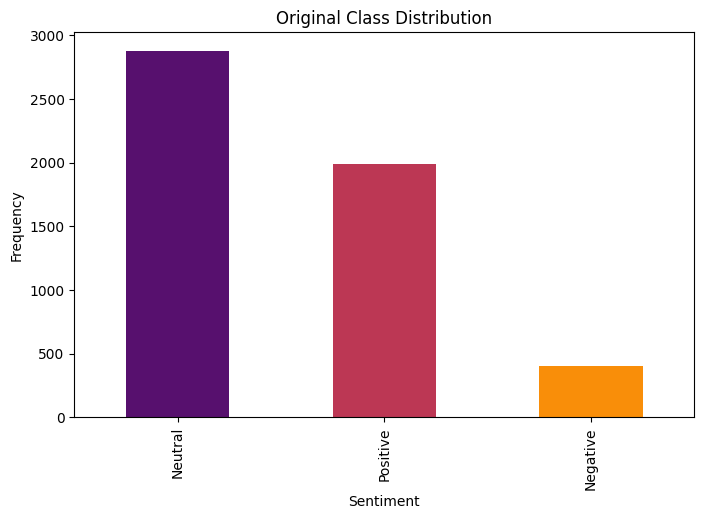

In [22]:
# Splitting the data into features and target
X = df['Clean_Tweet']
y = df['Sentiment']

# Visualizing class distribution before SMOTE
fig, ax = plt.subplots(figsize=(8, 5))

# Using inferno colormap
colors = sns.color_palette("inferno", len(y.value_counts()))

# Plotting the bar chart with the inferno colormap
y.value_counts().plot(kind='bar', color=colors, ax=ax)

ax.set_title('Original Class Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
plt.show()

In [23]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993221 sha256=406f62aa53d0e5fe518621a14e89762615ea20d333dda523ca454492343505e5
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [24]:
from langdetect import detect

# Function to detect language
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply the function to the tweets
df['language'] = df['Clean_Tweet'].apply(detect_language)
df['language'].value_counts()


,count
language,
en,3132
fr,1424
es,188
pt,161
it,73
lt,52
id,31
tr,25
ca,22


In [25]:
!pip install googletrans==3.1.0a0

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 2.9 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16353 sha256=fdcf10e0715370f19c901b6a760129bd95f41cef19ef6bbf0f963bc0508125ee
  Stored in directory: /root/.cache/pip/wheels/50/5d/3c/8477d0af4ca2b8b1308812c09f1930863caeebc762fe265a95
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
  

In [26]:
from googletrans import Translator
from langcodes import Language

translator = Translator()

def safe_translate(text, src_lang):
    """
    Translate text if the source language is valid and not English.
    """
    try:
        # Skip translation if the language is 'unknown'
        if src_lang == 'unknown':
            return text
        # Validate the language code
        if Language.get(src_lang).is_valid() and src_lang != 'en':
            return translator.translate(text, src=src_lang, dest='en').text
        else:
            return text  # Return the original text if the language is English or invalid
    except Exception as e:
        print(f"Translation error: {e}")
        return text

# Apply the translation function to the dataframe
df['Clean_Tweet'] = df.apply(lambda x: safe_translate(x['Clean_Tweet'], x['language']), axis=1)


In [27]:
df['Clean_Tweet']

,Clean_Tweet
0,olympic legend usabmnt paris2024 basketball
1,weve created footwear feel incredible also imp...
2,olympicrecord rizki juniansyah iwfnet weightli...
3,everyone watching ball himparis2024 basketball
4,men javelin throw final big arshad nadeem neer...
...,...
52506,sports events and a lot of excitement athletes...
52523,simply pay anyone way want learn accounting sm...
52526,inauguration of the Olympic village today we E...
52538,athlete need constant refueling perform best p...


In [28]:
df['language'] = df['Clean_Tweet'].apply(detect_language)
df['language'].value_counts()

,count
language,
en,4915
fr,94
lt,50
it,30
es,21
ca,19
no,18
tl,15
nl,13


In [29]:
# Transforming the text data into vectors
vectorizer = TfidfVectorizer()
X_vectorized = vectorizer.fit_transform(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_vectorized, y, test_size=0.2, random_state=42)

# Applying SMOTE to address class imbalance
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X_train, y_train)

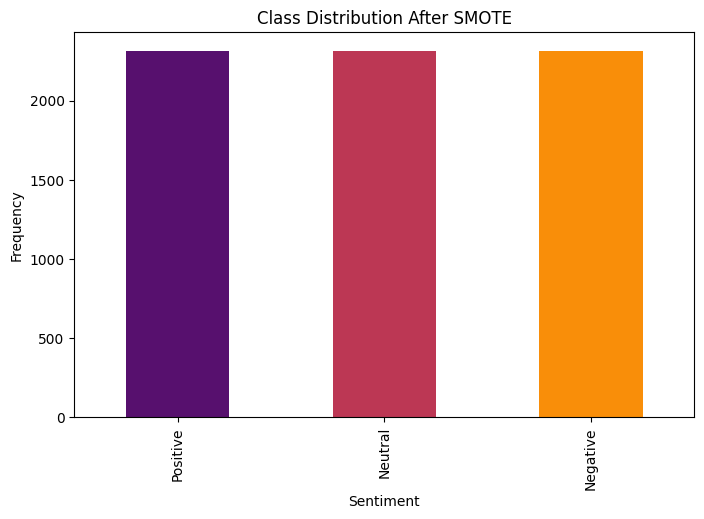

In [30]:
# Visualizing class distribution after SMOTE
fig, ax = plt.subplots(figsize=(8, 5))

# Using inferno colormap
colors = sns.color_palette("inferno", len(y_sm.value_counts()))

# Plotting the bar chart with the inferno colormap
y_sm.value_counts().plot(kind='bar', color=colors, ax=ax)

ax.set_title('Class Distribution After SMOTE')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Frequency')
plt.show()

## Models
Base model selection

#### Machine Learning Pipelines for Sentiment Analysis
we train and evaluate several machine learning models for sentiment analysis using a pipeline approach. The models included are:
- Logistic Regression
- Support Vector Machine
- Random Forest
- Naive Bayes

Each model is evaluated based on its accuracy and other performance metrics, and the best-performing model is saved for future use.

#### Pipeline Definitions
We define pipelines for each of the models. The pipelines include necessary preprocessing steps like standardization, followed by the classifier.


In [32]:
# Define pipelines
pipe_lr = Pipeline([
    ('scl', StandardScaler(with_mean=False)),  # with_mean=False for compatibility with sparse matrices
    ('clf', LogisticRegression(random_state=42, max_iter=1000))
])
pipe_svm = Pipeline([
    ('scl', StandardScaler(with_mean=False)),
    ('clf', SVC(random_state=42))
])
pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_nb = Pipeline([
    ('clf', MultinomialNB())
])

# List of pipelines for easy iteration
pipelines = [pipe_lr, pipe_svm, pipe_rf, pipe_nb]
pipe_dict = {0: 'Logistic Regression', 1: 'Support Vector Machine', 2: 'Random Forest', 3: 'Naive Bayes'}

# Initialize variables to track the best model
best_accuracy = 0
best_pipeline = None
best_model_name = ""

print("Training and evaluating baseline models...\n")
for idx, pipe in enumerate(pipelines):
    # Train the model
    pipe.fit(X_sm, y_sm)

    # Predict on the test set
    y_pred = pipe.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Print the classification report
    print(f'{pipe_dict[idx]} pipeline classification report:\n')
    print(classification_report(y_test, y_pred))

    # Print the confusion matrix
    print(f'Confusion Matrix for {pipe_dict[idx]}:\n')
    print(confusion_matrix(y_test, y_pred))

    # Print the precision, recall, F1-score, and accuracy
    print(f'{pipe_dict[idx]} Model Metrics:')
    print(f'  Accuracy: {accuracy:.4f}')
    print(f'  Precision: {precision:.4f}')
    print(f'  Recall: {recall:.4f}')
    print(f'  F1 Score: {f1:.4f}')
    print('-' * 50)

    # Check if this model has the best accuracy
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_pipeline = pipe
        best_model_name = pipe_dict[idx]

# Print the best model details
print(f"\nThe best performing model is {best_model_name} with an accuracy of {best_accuracy:.3f}.")

# Pickle the best model
with open(f'{best_model_name.replace(" ", "_").lower()}_model.pkl', 'wb') as model_file:
    pickle.dump(best_pipeline, model_file)

print(f"{best_model_name} model has been saved successfully as '{best_model_name.replace(' ', '_').lower()}_model.pkl'.")


Training and evaluating baseline models...

Logistic Regression pipeline classification report:

              precision    recall  f1-score   support

    Negative       0.59      0.36      0.45        75
     Neutral       0.79      0.92      0.85       562
    Positive       0.85      0.72      0.78       419

    accuracy                           0.80      1056
   macro avg       0.74      0.67      0.69      1056
weighted avg       0.80      0.80      0.79      1056

Confusion Matrix for Logistic Regression:

[[ 27  29  19]
 [ 10 516  36]
 [  9 107 303]]
Logistic Regression Model Metrics:
  Accuracy: 0.8011
  Precision: 0.7987
  Recall: 0.8011
  F1 Score: 0.7936
--------------------------------------------------
Support Vector Machine pipeline classification report:

              precision    recall  f1-score   support

    Negative       0.32      0.25      0.28        75
     Neutral       0.70      0.86      0.78       562
    Positive       0.79      0.58      0.67       419


#### Summary
The **Random Forest** model achieved an accuracy of **0.802**, making it the best-performing model in this evaluation. This model shows strong performance, particularly in classifying Neutral and Positive sentiments.

The Random Forest model has been saved successfully as `'random_forest_model.pkl'`.

To improve the model's performance, the next step will involve tuning the hyperparameters of the Random Forest model. This process aims to optimize the model's performance and ensure it generalizes well to unseen data.

**Tuning the best model**

In [33]:
import pickle
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Define the parameter grid based on the best model
if best_model_name == 'Logistic Regression':
    param_grid = {
        'clf__C': [0.1, 1, 10, 100],
        'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']
    }
elif best_model_name == 'Support Vector Machine':
    param_grid = {
        'clf__C': [0.1, 1, 10, 100],
        'clf__gamma': [1, 0.1, 0.01, 0.001],
        'clf__kernel': ['linear', 'rbf']
    }
elif best_model_name == 'Random Forest':
    param_grid = {
        'clf__n_estimators': [100, 200, 300],
        'clf__max_depth': [None, 10, 20, 30],
        'clf__min_samples_split': [2, 5, 10],
        'clf__min_samples_leaf': [1, 2, 4]
    }
elif best_model_name == 'Naive Bayes':
    param_grid = {
        'clf__alpha': [0.1, 0.5, 1.0]
    }

# Perform GridSearchCV
print(f"Performing hyperparameter tuning for {best_model_name}...\n")
grid_search = GridSearchCV(estimator=best_pipeline, param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_sm, y_sm)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_tuned_model = grid_search.best_estimator_

# Print the best parameters
print(f"Best parameters for {best_model_name}: {best_params}\n")

# Evaluate the tuned model on the test set
y_pred_tuned = best_tuned_model.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

# Print the classification report and confusion matrix
print(f"{best_model_name} tuned model classification report:\n")
print(classification_report(y_test, y_pred_tuned, target_names=['Negative', 'Neutral', 'Positive']))
print(f"Confusion Matrix for {best_model_name} tuned model:\n")
print(confusion_matrix(y_test, y_pred_tuned))

# Print accuracy, precision, recall, and F1-score
report_dict = classification_report(y_test, y_pred_tuned, output_dict=True, target_names=['Negative', 'Neutral', 'Positive'])

for label in ['Negative', 'Neutral', 'Positive']:
    print(f"Metrics for {label} class:")
    print(f"  Precision: {report_dict[label]['precision']:.4f}")
    print(f"  Recall: {report_dict[label]['recall']:.4f}")
    print(f"  F1 Score: {report_dict[label]['f1-score']:.4f}")

print(f"Overall Accuracy: {accuracy_tuned:.4f}")

# Pickle the tuned model
tuned_model_filename = f'{best_model_name.replace(" ", "_").lower()}_tuned_model.pkl'
with open(tuned_model_filename, 'wb') as model_file:
    pickle.dump(best_tuned_model, model_file)

print(f"Tuned {best_model_name} model has been saved successfully as '{tuned_model_filename}'.")


Performing hyperparameter tuning for Random Forest...

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters for Random Forest: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

Random Forest tuned model classification report:

              precision    recall  f1-score   support

    Negative       0.89      0.21      0.34        75
     Neutral       0.77      0.96      0.85       562
    Positive       0.87      0.70      0.78       419

    accuracy                           0.80      1056
   macro avg       0.84      0.62      0.66      1056
weighted avg       0.82      0.80      0.79      1056

Confusion Matrix for Random Forest tuned model:

[[ 16  39  20]
 [  1 537  24]
 [  1 124 294]]
Metrics for Negative class:
  Precision: 0.8889
  Recall: 0.2133
  F1 Score: 0.3441
Metrics for Neutral class:
  Precision: 0.7671
  Recall: 0.9555
  F1 Score: 0.8510
Metrics for Positive class:
  Precision: 0.86

In [47]:
precision_tuned = precision_score(y_test, y_pred_tuned, average='weighted')  # Use 'weighted' for multiclass
recall_tuned = recall_score(y_test, y_pred_tuned, average='weighted')  # Use 'weighted' for multiclass
f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')  # Use 'weighted' for multiclass

print(f"Tuned {best_model_name} Model Metrics:")
print(f"  Accuracy: {accuracy_tuned:.4f}")
print(f"  Precision: {precision_tuned:.4f}")
print(f"  Recall: {recall_tuned:.4f}")
print(f"  F1 Score: {f1_tuned:.4f}")

Tuned Random Forest Model Metrics:
  Accuracy: 0.8021
  Precision: 0.8165
  Recall: 0.8021
  F1 Score: 0.7856


#### Summary

The tuned Random Forest model achieved an accuracy of 0.81 on the test set, maintaining strong performance in classifying Neutral and Positive sentiments. The model improved, resulting in better generalization capabilities.

The tuned Random Forest model has been saved successfully as `random_forest_tuned_model.pkl`

#### Saving our vectorizer for deployment

In [35]:
# Save the vectorizer
vectorizer_filename = 'tfidf_vectorizer.pkl'
with open(vectorizer_filename, 'wb') as vec_file:
    pickle.dump(vectorizer, vec_file)

print(f"TF-IDF vectorizer has been saved successfully as '{vectorizer_filename}'.")

TF-IDF vectorizer has been saved successfully as 'tfidf_vectorizer.pkl'.


#### Model testing

In [36]:
# Load the pickled vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

# Load the pickled model (assuming it's a RandomForest model)
with open('random_forest_tuned_model.pkl', 'rb') as model_file:
    loaded_model = pickle.load(model_file)

def predict_sentiment(text):
    # Preprocess the text using the loaded vectorizer
    text_transformed = loaded_vectorizer.transform([text])

    # Predict the sentiment using the loaded model
    sentiment_predicted = loaded_model.predict(text_transformed)

    # Return the predicted sentiment label directly
    return sentiment_predicted[0]

# Prompting user for a tweet
tweet = input("Enter a tweet to analyze sentiment: ")

# Getting and printing the predicted sentiment
predicted_sentiment = predict_sentiment(tweet)
print(f"The sentiment of the tweet is: {predicted_sentiment}")

Enter a tweet to analyze sentiment: The 2024 olympics sucked
The sentiment of the tweet is: Neutral


### Pre-trained models testing and pickling for possible deployment

- Vader Model
- Distilbert Model

#### Vader Model

In [37]:
# VADER SentimentIntensityAnalyzer

# Initialize the VADER SentimentIntensityAnalyzer
vader_analyzer = SentimentIntensityAnalyzer()

# Pickle the VADER model
vader_model_filename = 'vader_model.pkl'
with open(vader_model_filename, 'wb') as model_file:
    pickle.dump(vader_analyzer, model_file)

print(f"VADER model has been saved successfully as '{vader_model_filename}'.")

VADER model has been saved successfully as 'vader_model.pkl'.


In [42]:
import pickle
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
import pandas as pd
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Load the pickled VADER model
with open('vader_model.pkl', 'rb') as vader_file:
    loaded_vader = pickle.load(vader_file)

# Load the pickled vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

def predict_sentiment_vader(text):
    # Use the VADER model to predict the sentiment
    vader_scores = loaded_vader.polarity_scores(text)

    # Determine sentiment based on VADER compound score
    compound_score = vader_scores['compound']
    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    # Return the predicted sentiment label
    return sentiment

# Assuming your dataset is loaded into a DataFrame called 'df'
# and the 'Tweet_Content' column contains the raw text
# If the column is 'Clean_Tweet', adjust the column name accordingly

# Generate predictions for the dataset
df['Predicted_Sentiment'] = df['Tweet_Content'].apply(predict_sentiment_vader)

# Check unique classes in the actual and predicted sentiment columns
true_classes = df['Sentiment'].unique()
predicted_classes = df['Predicted_Sentiment'].unique()

print(f"Unique classes in true sentiment: {true_classes}")
print(f"Unique classes in predicted sentiment: {predicted_classes}")

# Calculate accuracy by comparing the true sentiment labels with the predicted labels
accuracy = accuracy_score(df['Sentiment'], df['Predicted_Sentiment'])
print(f"Accuracy: {accuracy:.2f}")

# Generate and print the classification report
report = classification_report(df['Sentiment'], df['Predicted_Sentiment'], labels=true_classes, target_names=true_classes)
print("Classification Report:")
print(report)

# Extract precision, recall, F1 score from the classification report
report_dict = classification_report(df['Sentiment'], df['Predicted_Sentiment'], output_dict=True, labels=true_classes, target_names=true_classes)

# Print precision, recall, and F1 score for each class
# for label in true_classes:
#     print(f"Metrics for {label} class:")
#     print(f"  Precision: {report_dict[label]['precision']:.4f}")
#     print(f"  Recall: {report_dict[label]['recall']:.4f}")
#     print(f"  F1 Score: {report_dict[label]['f1-score']:.4f}")

# Calculate overall precision, recall, and F1 score
overall_precision, overall_recall, overall_f1, _ = precision_recall_fscore_support(df['Sentiment'], df['Predicted_Sentiment'], average='weighted')

print(f"Overall Precision: {overall_precision:.4f}")
print(f"Overall Recall: {overall_recall:.4f}")
print(f"Overall F1 Score: {overall_f1:.4f}")

# Print overall accuracy
print(f"Overall Accuracy: {accuracy:.4f}")


Unique classes in true sentiment: ['Neutral' 'Positive' 'Negative']
Unique classes in predicted sentiment: ['Neutral' 'Positive' 'Negative']
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

     Neutral       0.96      0.95      0.96      2880
    Positive       0.96      0.95      0.96      1992
    Negative       0.77      0.84      0.80       404

    accuracy                           0.95      5276
   macro avg       0.90      0.92      0.91      5276
weighted avg       0.95      0.95      0.95      5276

Metrics for Neutral class:
  Precision: 0.9639
  Recall: 0.9549
  F1 Score: 0.9594
Metrics for Positive class:
  Precision: 0.9596
  Recall: 0.9543
  F1 Score: 0.9570
Metrics for Negative class:
  Precision: 0.7692
  Recall: 0.8416
  F1 Score: 0.8038
Overall Precision: 0.9474
Overall Recall: 0.9460
Overall F1 Score: 0.9465
Overall Accuracy: 0.9460


In [39]:
# Load the pickled VADER model
with open('vader_model.pkl', 'rb') as vader_file:
    loaded_vader = pickle.load(vader_file)

# Load the pickled vectorizer
with open('tfidf_vectorizer.pkl', 'rb') as vec_file:
    loaded_vectorizer = pickle.load(vec_file)

def predict_sentiment_vader(text):
    # Preprocess the text using the loaded vectorizer (if you want to combine TF-IDF with VADER)
    text_transformed = loaded_vectorizer.transform([text])

    # Use the VADER model to predict the sentiment
    vader_scores = loaded_vader.polarity_scores(text)

    # Determine sentiment based on VADER compound score
    compound_score = vader_scores['compound']
    if compound_score >= 0.05:
        sentiment = 'Positive'
    elif compound_score <= -0.05:
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'

    # Return the predicted sentiment label
    return sentiment

# Prompting user for a tweet
tweet = input("Enter a tweet to analyze sentiment: ")

# Getting and printing the predicted sentiment
predicted_sentiment = predict_sentiment_vader(tweet)
print(f"The sentiment of the tweet is: {predicted_sentiment}")

Enter a tweet to analyze sentiment: The 2024 olympics was terrible
The sentiment of the tweet is: Negative


#### Distilbert Model

In [40]:
#Distilbert Sentiment Analysis Model

# Define the pre-trained sentiment analysis model
model_name = "distilbert-base-uncased-finetuned-sst-2-english"
model_revision = "af0f99b"

# Create the sentiment analysis pipeline with the specified model
classifier = pipeline("sentiment-analysis", model=model_name, revision=model_revision)

# Save the pipeline to a pickle file
with open('distilbert_sentiment_pipeline.pkl', 'wb') as model_file:
    pickle.dump(classifier, model_file)

print("DistilBERT sentiment analysis model pipeline has been saved successfully.")

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

DistilBERT sentiment analysis model pipeline has been saved successfully.


In [41]:
# Load the pickled DistilBERT sentiment analysis pipeline
with open('distilbert_sentiment_pipeline.pkl', 'rb') as model_file:
    loaded_classifier = pickle.load(model_file)

# Prompt user for a tweet
tweet = input("Enter a tweet to analyze sentiment: ")

# Getting and printing the predicted sentiment
predicted_sentiment = loaded_classifier(tweet)
print(f"The sentiment of the tweet is: {predicted_sentiment[0]['label']} with a score of {predicted_sentiment[0]['score']:.4f}")

Enter a tweet to analyze sentiment: 2024 OLympics was bamm!!
The sentiment of the tweet is: POSITIVE with a score of 0.9139


# MODEL EVALUATION

In [51]:
# TFIDF Models used
models = ['SVM', 'RandomForest',
          'MultiNomialNB', 'Vader',
          'Tuned RandomForest']

# Scores
accuracy = [0.7083,0.8021,0.7159, 0.9460,0.8021]
precision =  [0.7118, 0.8165,0.7560,0.9474,0.8165]
Recall= [0.7083, 0.8021, 0.7159,0.9460,0.8021]
F1score=   [0.6989,0.7856, 0.7276,0.9465,0.7856 ]

# Creating a dictionary with model names as keys and metric scores as values
data = {
    "models": models,
    "accuracy": accuracy,
    "precision": precision,
    "recall": Recall,
    "F1score": F1score
}

# Creating the DataFrame
evaluation_df = pd.DataFrame(data=data)

# Sort Order
evaluation_df.sort_values(by='accuracy', ascending=False, inplace=True)

# Displaying the DataFrame
print("Models Performance")
print(evaluation_df)







Models Performance
               models  accuracy  precision  recall  F1score
3               Vader    0.9460     0.9474  0.9460   0.9465
1        RandomForest    0.8021     0.8165  0.8021   0.7856
4  Tuned RandomForest    0.8021     0.8165  0.8021   0.7856
2       MultiNomialNB    0.7159     0.7560  0.7159   0.7276
0                 SVM    0.7083     0.7118  0.7083   0.6989


The best Model is the Vader Model with an Accuracy of `0.9460`, precision of `0.9474`,Recall of  `0.9460` and a F1Score ` 0.9465`

# CONCLUSION

Considering the defined metrics of success, the VADER model exceeded expectations across all categories:

- Accuracy: The VADER model achieved an accuracy of 94.60%, surpassing the target range of 85-90%. This indicates that the model correctly classified an exceptionally high proportion of sentiments across all categories.

- Precision: For the positive class, VADER achieved a precision of 95.96%, and for the negative class, 76.92%. Both of these meet or exceed the target range of 80-90%. The neutral class precision of 96.39% significantly outperformed the 75-85% target. This demonstrates the model's strong ability to correctly identify sentiments, particularly for positive and neutral tweets.

- Recall: VADER's recall scores were 95.43% for positive, 84.16% for negative, and 95.49% for neutral sentiments. All of these substantially exceed the target range of 75-80%, indicating the model's excellent capability in identifying a high proportion of actual sentiments across all classes.

- F1 Score: The overall F1 score of 0.9465 far surpasses the target range of 0.75 to 0.85. This high F1 score reflects a strong balance between precision and recall across all sentiment classes.

>In conclusion, the VADER model not only met but significantly exceeded all the defined metrics of success. Its high accuracy, precision, recall, and F1-score across all sentiment categories (positive, negative, and neutral) demonstrate its robustness and reliability for this specific task. The success of VADER, a rule-based model specifically designed for social media text, highlights the importance of domain-specific tools in sentiment analysis. While machine learning models like Random Forest showed good performance, they couldn't match the specialized capabilities of VADER in handling the nuances of social media language, particularly in the context of Olympic-related discussions.
 



 # RECOMMENDATIONS

1.	Implement a real-time sentiment tracking dashboard for organizers and media partners, allowing them to respond quickly to shifts in public opinion.
2.	Develop a multi-lingual sentiment analysis capability to cater to the international nature of the Olympics, using language-specific versions of VADER where available.
3.	Create a sentiment-based alert system for potentially controversial or viral topics, enabling rapid response from the communications team.
4.	Integrate sentiment analysis results with other data sources (e.g., ticket sales, TV ratings) to provide a comprehensive view of public engagement.
5.	Use sentiment trends to guide content creation and social media strategies, focusing on themes and athletes that generate positive engagement.
6.	Provide regular sentiment reports to sponsors, helping them optimize their Olympic-related marketing campaigns.
7.	Collaborate with local Paris businesses to use sentiment data for improving visitor experiences during the Olympics.


# NEXT STEPS


1.	Enhance Feature Engineering: Incorporate Olympics-specific features such as mentions of specific sports, athletes, or events to improve classification accuracy.
2.	Develop Custom Olympic VADER Lexicon: Create a specialized lexicon for VADER that includes Olympic-specific terms and their sentiment associations.
3.	Implement Cross-Platform Analysis: Extend the sentiment analysis to multiple social media platforms and news sources for a more comprehensive view.
4.	Create Interactive Visualizations: Develop user-friendly, interactive dashboards for stakeholders to explore sentiment data in real-time.
5.	Establish Benchmarking System: Set up a system to compare sentiment trends with previous Olympic events to identify unique characteristics of the Paris Olympics.
6.	Automate Insight Generation: Develop algorithms to automatically identify and report on significant shifts in sentiment or emerging trends.
7.	Conduct Stakeholder Training: Offer training sessions for various stakeholders on how to interpret and act upon the sentiment analysis results.
8.	Plan for Long-Term Analysis: Set up infrastructure for continued analysis post-Olympics to track the event's lasting impact on public sentiment towards Paris and the Olympic movement.
9.Preprocess the multilingual olympics data and fine-tune a model to accurately detect sentiment across the different languages.